TODO list
- Get some measure of what a good grouping is
- Add more scalable way to see results are changing grouping
- Why do we not see the first row in summary statistics
- Fully interpreting the betas and the offset (bias term?) parameter
- Read Montgomery text on Poisson regression

# Insurance pricing with Generalized Linear models

We want to price a tractor __insurance policy__ for the new year, and to do this we want to do this by using data from our previous interactions with customers. For each customer, we have __factors__ (or features if you're from an ML background or variables if you're from a stats background). 

Typically we divide the factors into __groups__, for example if vehicle age is a factor, one possible division is 0-1 years, 1-2 years, 2-4 years, 4+ years. Once we divided all of our factors into such groups, we now come to what is called a tariff cell. A __tariff cell__ is simply one possible combination of each of the groups. For example, we might have 3 factors, lets call them factor $A,B,C$. Factor $A$ might have 3 groups, called $a_1,a_2,a_3$. $B$ has groups $b_1,b_2$ and $C$ has groups $c_1,c_2$. In this case the tariff cells would be $(a_1,b_1,c_1), (a_1,b_1,c_2), (a_1,b_2,c_1), (a_1,b_2,c_2), (a_2,b_1,c_1) .... (a_3,b_2,c_2)$. Given $n$ factors $f_1, f_2, ..., f_n$ and if factor $i$ has $N_i$ groups, there are $\prod_{k=1}^n N_k$ tariff cells in total.

For each group in each factor we assign what is called a __risk factor__. We denote $\gamma_{k,i}$ as the risk factor for the $i^{th}$ group of factor $k$. We want a model to price the insurance policy for each tariff cell, so we assume that each tariff cell is associated with a multiplicative risk. We introduce what is called a total risk factor 
$$
\gamma_0 \prod_{k=1}^n \gamma_{k,i_k}
$$
where $i_k$ is the group relevant to factor $k$ for which the tariff is computed for, and $\gamma_0$ is some base level which we determine at the end to match the final amount we will charge the customer, called the __insurance premium__.

We proceed by modelling the cost the insurer will probably have to pay out. We call this quantity the __Risk__. We can say this is the average number of claims per year multiplied by the average cost per claim for that tariff cell. The average number of claims is called the __Claim frequency__ and the average cost per claim is called the __Claim severity__. We can use this to link the Risk to the total cost of the claims and the total __insurance years__ ???

$$ Risk = Claim \: frequency \times Claim \: severity \\ \\
= \frac{Number \: of \: claims}{Insurance \: years} \times \frac{Total \: claim \: cost}{Number \: of \: claims}
= \frac{Total \: claim \: costs}{Insurance \: years}
$$

We call the Claim frequency and Claim severity key ratios, as they represent a response quantity which we can model as a random variable divided by some measure related to that quantity, which we call the exposure. They are of the form
$$
X_i = \frac{Y_i}{w_i}
$$


Long story short, we want to do the following
1. Grouping
    - Given some factors divide them into groups such that each group is more or less __risk homogeneous__, i.e. the risk does not vary much within the group, with regard to that particular factor.
    - Create groups with enough data to get a stable GLM analysis for each group. What is "enough" has no clear answer, bur varies, depending among other things on how many variables you use in your analysis.
2. Leveling i.e. computing the base factor $\gamma_0$ (Note for this part remember to only use insurances that are active i.e. have the full year's duration at the end of 2016)
    - Estimate the claim cost for the coming year for each tariff group, i.e. assuming that the current customers who have stayed with us until the end of 2016 would extend their insurance for the next year, what would the claim cost be for these insurances (by an insurance we mean one customer)
    - Assuming that we want the total estimated claim cost to be 90% of the total premium, what should the total sum of tractor's premium be to accomodate this target?
    - For each insurance, compute the total risk factor and then compute the base level $\gamma_0$ that makes the total premium match what we have computed above

In [1]:
# install relevant packages
# we assume that the csv file is in the same directory
install.packages("ggplot2")
install.packages("foreach")
#install.packages("xlsx")

library(ggplot2)
library(foreach)
#library(xlsx)

Installing package into ‘/usr/local/lib/R/3.6/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/3.6/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/3.6/site-library’
(as ‘lib’ is unspecified)



In [79]:
# function for plotting the data

multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)
  
  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)
  
  numPlots = length(plots)
  
  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                     ncol = cols, nrow = ceiling(numPlots/cols))
  }
  
  if (numPlots==1) {
    print(plots[[1]])
    
  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    
    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
      
      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [85]:
######################### Section 1: Read data #########################

# This is where your GLM data is read form tractors.csv into a table in R 
# Note that the folder in which you have tractors.csv must be set as the working directory 
###### You do not need to change anything in this section. The data will be sotred in a table named glmdata

glmdata <- read.table("Tractors.csv", header=TRUE, sep=";", dec=",",stringsAsFactors=FALSE )

In [86]:
# Always start by looking at the data we have

glmdata

RiskYear,VehicleAge,Weight,Climate,ActivityCode,Duration,NoOfClaims,ClaimCost
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>
2012,9,3830,North,F - Construction,0.6264176,1,627099.20
2011,4,3700,South,F - Construction,0.8120670,1,257454.78
2012,4,6500,South,F - Construction,0.3912562,1,257159.10
2010,1,400,South,Missing,0.5922617,1,253849.76
2016,0,3290,South,"G - Wholesale & retail trade; repair of motor vehicles, household",0.3434338,1,248545.53
2008,6,5210,South,Missing,0.3957998,1,245361.37
2011,8,4200,South,"A - Agriculture, Hunting and Forestry",0.7116363,1,238407.48
2013,0,1000,South,Missing,0.4638781,1,176349.40
2007,7,15000,South,"A - Agriculture, Hunting and Forestry",0.4728304,1,174841.00


After looking at the data we have, we can see that we have 4 factors that relate to 
- the vehicles age
- its weight
- the climate it operates in 
- the type of activity it does

The duration column represents the proportion of the year the tractor has had the insurance. For example, if someone buys a one year insurance policy halfway through 2010, there will be 2 rows for that tractor, one with the risk year as 2010 and the other for 2011 both with a duration of 0.5. This is important when computing the base factor, since we have to only use insurances which are continuing onto the next year. Assuming that insurance policies are only sold on a one year basis, we want to check how many of the insurances with the risk year 2016 actually ended during the year. To do this, for each tractor in 2016 we take all other tractors which share the tariff cell and check if the duration of that tractor in 2016 matches the 2015 duration of any tractor we are compariing with such that they sum to 1 (or equivalently run a double for loop with all policies in 2016 and 2015 and marking all those whose durations sum to one and are in the same tariff cell). This implies that the 2016 tractor has ended its insurance policy during the year 2016. 

We now start with grouping

In [132]:
######################### Section 2: Create groups & aggregate data #########################

# Now you need to modify your data so that you can perform a GLM analysis 

# First, any continuous variable needs to be grouped into discrete groups 
# The code below groups the variable weight, from you table glmdata, into six groups, 
# and stores this in a new column, weight_group 
# It also groups the variable VehicleAge into four groups
###### This is only an example. You need to create your own groups, with breaks that suit your data
###### You might also want to group other variables from glmdata, in a similar manner

glmdata$weight_group <- cut(glmdata$Weight, 
                       breaks = c(-Inf, 1000, 2000, 3000, 4000, 5000, Inf), 
                       labels = c("01_<1000kg", "02_1000-1999kg", "03_2000-2999kg", "04_3000-3999kg", "05_4000-4999kg", "06_>=5000kg"), 
                       right = FALSE)

glmdata$age_group <- cut(glmdata$VehicleAge, 
                            breaks = c(-Inf, 3, 6, 15, Inf), 
                            labels = c("01_<3years", "02_3-6years", "03_6-15years", "04_>15years"), 
                            right = FALSE)

[1] 10

RiskYear,VehicleAge,Weight,Climate,ActivityCode,Duration,NoOfClaims,ClaimCost,weight_group,age_group,activity_group
<int>,<int>,<int>,<fct>,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>
2012,9,3830,North,F - Construction,0.6264176,1,627099.20,04_3000-3999kg,03_6-15years,FG
2011,4,3700,South,F - Construction,0.8120670,1,257454.78,04_3000-3999kg,02_3-6years,FG
2012,4,6500,South,F - Construction,0.3912562,1,257159.10,06_>=5000kg,02_3-6years,FG
2010,1,400,South,Missing,0.5922617,1,253849.76,01_<1000kg,01_<3years,Mi
2016,0,3290,South,"G - Wholesale & retail trade; repair of motor vehicles, household",0.3434338,1,248545.53,04_3000-3999kg,01_<3years,FG
2008,6,5210,South,Missing,0.3957998,1,245361.37,06_>=5000kg,03_6-15years,Mi
2011,8,4200,South,"A - Agriculture, Hunting and Forestry",0.7116363,1,238407.48,05_4000-4999kg,03_6-15years,A
2013,0,1000,South,Missing,0.4638781,1,176349.40,02_1000-1999kg,01_<3years,Mi
2007,7,15000,South,"A - Agriculture, Hunting and Forestry",0.4728304,1,174841.00,06_>=5000kg,03_6-15years,A


In [133]:
# Secondly, we want to aggregate the data.
# Meaning instead of having one row per tractor we want one row for each existing combination of variables i.e. tariff
# This code aggregates columns 6-8 of glmdata, by three variables: weight_group, Climate, and ActivityCode 
# The aggregated data is stored in a new table, glmdata2 
##### You need to consider if there are any other variables you want to aggregate by, and modify the code accordingly 

# we are using our grouped version of activity 
glmdata2 <- aggregate(glmdata[,6:8],by=list(weight_group = glmdata$weight_group, 
                                            Climate = glmdata$Climate,
                                            ActivityCode = glmdata$ActivityCode,
                                            age_group = glmdata$age_group), FUN=sum, na.rm=TRUE)


In [92]:
glmdata2

weight_group,Climate,activity_group,age_group,Duration,NoOfClaims,ClaimCost
<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>
01_<1000kg,Middle,AM,01_<2years,79.1619362,1,18048.64
02_1000-1999kg,Middle,AM,01_<2years,44.9533699,0,0.00
03_2000-2999kg,Middle,AM,01_<2years,6.7742480,0,0.00
04_3000-3999kg,Middle,AM,01_<2years,55.2067533,0,0.00
05_4000-4999kg,Middle,AM,01_<2years,52.3022946,2,107606.53
06_>=5000kg,Middle,AM,01_<2years,43.5851592,3,202503.28
01_<1000kg,North,AM,01_<2years,28.6921129,1,0.00
02_1000-1999kg,North,AM,01_<2years,8.7290712,0,0.00
03_2000-2999kg,North,AM,01_<2years,7.3264675,1,26071.21


In [125]:
# We then do some preparation for the output the GLM function will give.
# This piece of code creates a new table, glmdata3, with a row per variable and group, and with data on the
# total duration corresponding to this group.
##### You need ot modify the code to take into account any changes in variables you're using 


# here again we modified ActivityCode to activity_group
glmdata3 <-
  data.frame(rating.factor =
               c(rep("Weight", nlevels(glmdata2$weight_group)),
                 rep("Climate", nlevels(glmdata2$Climate)),
                 rep("ActivityCode", nlevels(glmdata2$ActivityCode)),
                 rep("Age", nlevels(glmdata2$age_group))),
             class =
               c(levels(glmdata2$weight_group),
                 levels(glmdata2$Climate),
                 levels(glmdata2$ActivityCode),
                 levels(glmdata2$age_group)),
             stringsAsFactors = FALSE)

new.cols <-
  foreach (rating.factor = c("weight_group", "Climate", "ActivityCode", "age_group"),
           .combine = rbind) %do%
           {
             nclaims <- tapply(glmdata2$NoOfClaims, glmdata2[[rating.factor]], sum)
             sums <- tapply(glmdata2$Duration, glmdata2[[rating.factor]], sum)
             n.levels <- nlevels(glmdata2[[rating.factor]]) #removing this line gives subscript out of bounds error
             contrasts(glmdata2[[rating.factor]]) <-
              contr.treatment(n.levels)[rank(-sums, ties.method = "first"), ]
             data.frame(duration = sums, n.claims = nclaims)
           }

glmdata3 <- cbind(glmdata3, new.cols)
rm(new.cols)

In [94]:
glmdata3

,rating.factor,class,duration,n.claims
,<chr>,<chr>,<dbl>,<int>
01_<1000kg,Weight,01_<1000kg,21995.8389,79
02_1000-1999kg,Weight,02_1000-1999kg,10431.9245,101
03_2000-2999kg,Weight,03_2000-2999kg,4902.8440,34
04_3000-3999kg,Weight,04_3000-3999kg,8430.0699,95
05_4000-4999kg,Weight,05_4000-4999kg,4410.6035,83
06_>=5000kg,Weight,06_>=5000kg,4259.9868,96
Middle,Climate,Middle,21991.9321,188
North,Climate,North,8887.6077,89
South,Climate,South,23551.7278,211


Now we proceed to model the claim frequency. One model is to assume that claims come from a Poisson process, i.e. for any given time period the number of claims have a Poisson distribution. For each insurance we can model the claim frequency relative to the duration it is active for by simply multiplying the mean parameter with the duration. The Poisson distribution has the added benefit that indepedent Poisson distrbutions are closed under sums, with the mean parameter being the sum of their means. This motivates us to model the claim frequency for each tariff cell, which would also follow a Poisson distribution. Denote $X_i$ as the number of claims for the $i^{th}$  tariff cell, which has mean $\mu_i$ and duration $w_i$. This means for any given year, $\mu_i$ is the expected number of claims for the $i^{th}$ tariff cell if we assume $w_i=1$. This means $X_i$ has probability mass function

$$f_{X_i}(x_i ; w_i, \mu_i) = \frac{e^{-(w_i \mu_i)}(w_i \mu_i)^{x_i}}{x_i !}$$

The key ratio here is the claim frequency
$$
Y_i = \frac{X_i}{w_i}
$$

We can show that combining any two claim frequencies give a weighted average, since if we merge two claim counts and their respective durations, we get

$$
\frac{X_i+X_j}{w_i + w_j} = \frac{w_iY_i + w_jY_j}{w_i+w_j}
$$

We can move from $X_i$ to $Y_i$ by noting that the event $\{ Y_i = y_i\}$ is the same the event  $\{X_i = w_i y_i\}$
Before moving to Generalized Linear Models, as an exercise check if the Poisson distribution is from the exponential family.

Now, we aim to determine the  $\mu_i$ but as mentioned before, which is the mean parameter for $X_i$. 
In a normal situation, we would have the following model - 

$$
g(\mu_i) = \textbf{X}_i \beta
$$

But since we are interested in $Y_i$, we write this as

$$
g(Y_i) = g(\frac{\mu_i}{w_i}) = \textbf{X}_i \beta
$$

$g$ is the link function, which in this case is the $\log$ function. Using this log-link, we can get $Y_i$ as

$$
\log(\mu_i) = \log(w_i) + \textbf{X}_i \beta
$$

The $ \log(w_i) $ is called the offset. 

In [127]:
######################### Section 3: GLM analysis #########################

# Now we get to the fun part - the GLM analysis. It is performed using R's built in GLM function 

# First, we model the claims frequency. 
# The first part of this performs a GLM analysis, with glmdata2 as the data source modelling NoOfClaims, 
# by the Duration. It looks at three variables: weight_group, Climate, and ActivityCode.
##### This is where you can modify the model by adding or removing variables 

model.frequency <-
  glm(NoOfClaims ~ weight_group + Climate + ActivityCode + age_group + offset(log(Duration)),
      data = glmdata2, family = poisson)

# Then we save the coefficients resulting from the GLM analysis in an array
##### You should not need to modify this part of the code

rels <- coef(model.frequency)
rels <- exp(rels[1] + rels[-1])/exp(rels[1])
#rels[1] is the intercept, rels[-1] is everything besides the intercept
# above we get the actual factors 

# Finally, we attach the coefficients to the already prepared table glmdata3, in a column named rels.frequency
# There is no good way of doing this automatically, so we need to do some manual tricks
# This code creates a vector with 6 positions consisting of the integer 1, and then positions number 1-5 
# in the rels array. Then it attaches this to rows 1-6 of glmdata3, sorted from highest to lowest duration, 
# since the GLM data is on this form. In other words, the code takes the GLM coeffisients for the six weight 
# groups and saves those in glmdata3, in the rows corresponding to those groups.
# After that, it does the same thing for the rest of the GLM coefficients, belonging to climate 
# and activity code vairables.
##### You need to modify this code to suit your set of variables and groups, to make sure each 
# GLM coefficient is saved in the correct place.

# nlevels(glmdata2[["weight_group"]]) returns 6 becauses theres 6 levels to the weight factor

##### You need to modify this code
variableLevels <- c(nlevels(glmdata2[["weight_group"]]),
                 nlevels(glmdata2[["Climate"]]),
                 nlevels(glmdata2[["ActivityCode"]]),
                 nlevels(glmdata2[["age_group"]]))

#You do not need to modify this part
cs <- cumsum(variableLevels)
cs_rels <- cs
for(i in 1:length(variableLevels)){
  cs_rels[i] <- cs[i]-i
}

# The following code needs to be used at two different places so we put it in a function.
##### This part needs to be modified if you change which variables are included in the model, 
# but not if you change the groups inside a variable
attachRels <- function(rels_vec, vector, cs, cs_rels) {
  c(c(1, rels_vec[ 1 : cs_rels[1] ])[rank(-vector[ 1 : cs[1] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[1]+1) : cs_rels[2] ])[rank(-vector[ (cs[1]+1) : cs[2] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[2]+1) : cs_rels[3] ])[rank(-vector[ (cs[2]+1) : cs[3] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[3]+1) : cs_rels[4] ])[rank(-vector[ (cs[3]+1) : cs[4] ], ties.method = "first")])
}

# Use the function created above, you do not need to modify this part
glmdata3$rels.frequency <- attachRels(rels, glmdata3$duration, cs, cs_rels)



########################
# We then do the same thing again, now modelling severity instead of claim frequency.
# That means that, in this part, we want to look at the average claim. So first, we calculate the 
# average claim for each row in glmdata2
##### You should not need to change anything in this piece of code.

glmdata2$avgclaim=glmdata2$ClaimCost/glmdata2$NoOfClaims

# Then we do the same thing as we did when modelling claims frequency, but we look at average claim;
# A GLM analysis is run, the coefficients stored, and saved in a new column, named rels.severity, glmdata3
##### You need to modify this part of the code in the same way as you did for the GLM model for frequency.  
# Add or remove variables
##### Remember that, according to the project instructions, you need to use the same variables for the 
# severity as for the frequency.

# converting nan to 0 from average claims
is.nan.data.frame <- function(x)
do.call(cbind, lapply(x, is.nan))
glmdata2$avgclaim[is.nan(glmdata2$avgclaim)]<-0

model.severity <-
  glm(avgclaim ~ weight_group + Climate + ActivityCode + age_group ,
      data = glmdata2[glmdata2$avgclaim>0,], family = Gamma("log"), weight=NoOfClaims)

# You do not need to change this part
rels <- coef(model.severity)
rels <- exp( rels[1] + rels[-1] ) / exp( rels[1] )
glmdata3$rels.severity <- attachRels(rels, glmdata3$duration, cs, cs_rels)

# Finally, the final risk factor is calculated, as the product of the frequency and severity factors. 
##### You should not have to modify this coed.
##### Congratulations! You now have a model for the risk!
glmdata3$rels.risk <- with(glmdata3, rels.frequency*rels.severity)


In [109]:
summary(model.frequency)


Call:
glm(formula = NoOfClaims ~ weight_group + Climate + activity_group + 
    age_group + offset(log(Duration)), family = poisson, data = glmdata2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6533  -0.7314  -0.3750   0.2013   3.1303  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -6.03229    0.15076 -40.013  < 2e-16 ***
weight_group2    1.08086    0.15135   7.141 9.25e-13 ***
weight_group3    1.30755    0.16341   8.001 1.23e-15 ***
weight_group4    0.96855    0.21020   4.608 4.07e-06 ***
weight_group5    1.78426    0.16770  10.640  < 2e-16 ***
weight_group6    1.88055    0.16430  11.446  < 2e-16 ***
Climate2        -0.03768    0.10263  -0.367 0.713508    
Climate3         0.14492    0.12796   1.133 0.257411    
activity_group2  0.11569    0.13789   0.839 0.401466    
activity_group3  0.37598    0.16628   2.261 0.023746 *  
activity_group4  0.53480    0.16154   3.311 0.000931 ***
activity_group5  1.14031    0.15253 

Key points
1. All weight groups have coefficients which are statistically significant
2. All age groups have coefficients which are statistically significant

In [ ]:
# ideas from textbook Montgomery


In [112]:
summary(model.severity)


Call:
glm(formula = avgclaim ~ weight_group + Climate + activity_group + 
    age_group, family = Gamma("log"), data = glmdata2[glmdata2$avgclaim > 
    0, ], weights = NoOfClaims)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8147  -0.6201  -0.0553   0.3471   3.3044  

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.95736    0.18525  53.751  < 2e-16 ***
weight_group2    0.11477    0.19657   0.584   0.5601    
weight_group3    0.45710    0.20024   2.283   0.0238 *  
weight_group4    0.29910    0.29323   1.020   0.3092    
weight_group5    0.89185    0.21099   4.227 3.96e-05 ***
weight_group6    1.05984    0.20427   5.188 6.31e-07 ***
Climate2        -0.15472    0.13647  -1.134   0.2586    
Climate3        -0.01575    0.16043  -0.098   0.9219    
activity_group2 -0.21806    0.15786  -1.381   0.1691    
activity_group3 -0.13674    0.21349  -0.640   0.5228    
activity_group4  0.60742    0.22353   2.717   0.0073 ** 
activ

Key points
1. The heavier weigh groups have coefficients which are more statistically significant

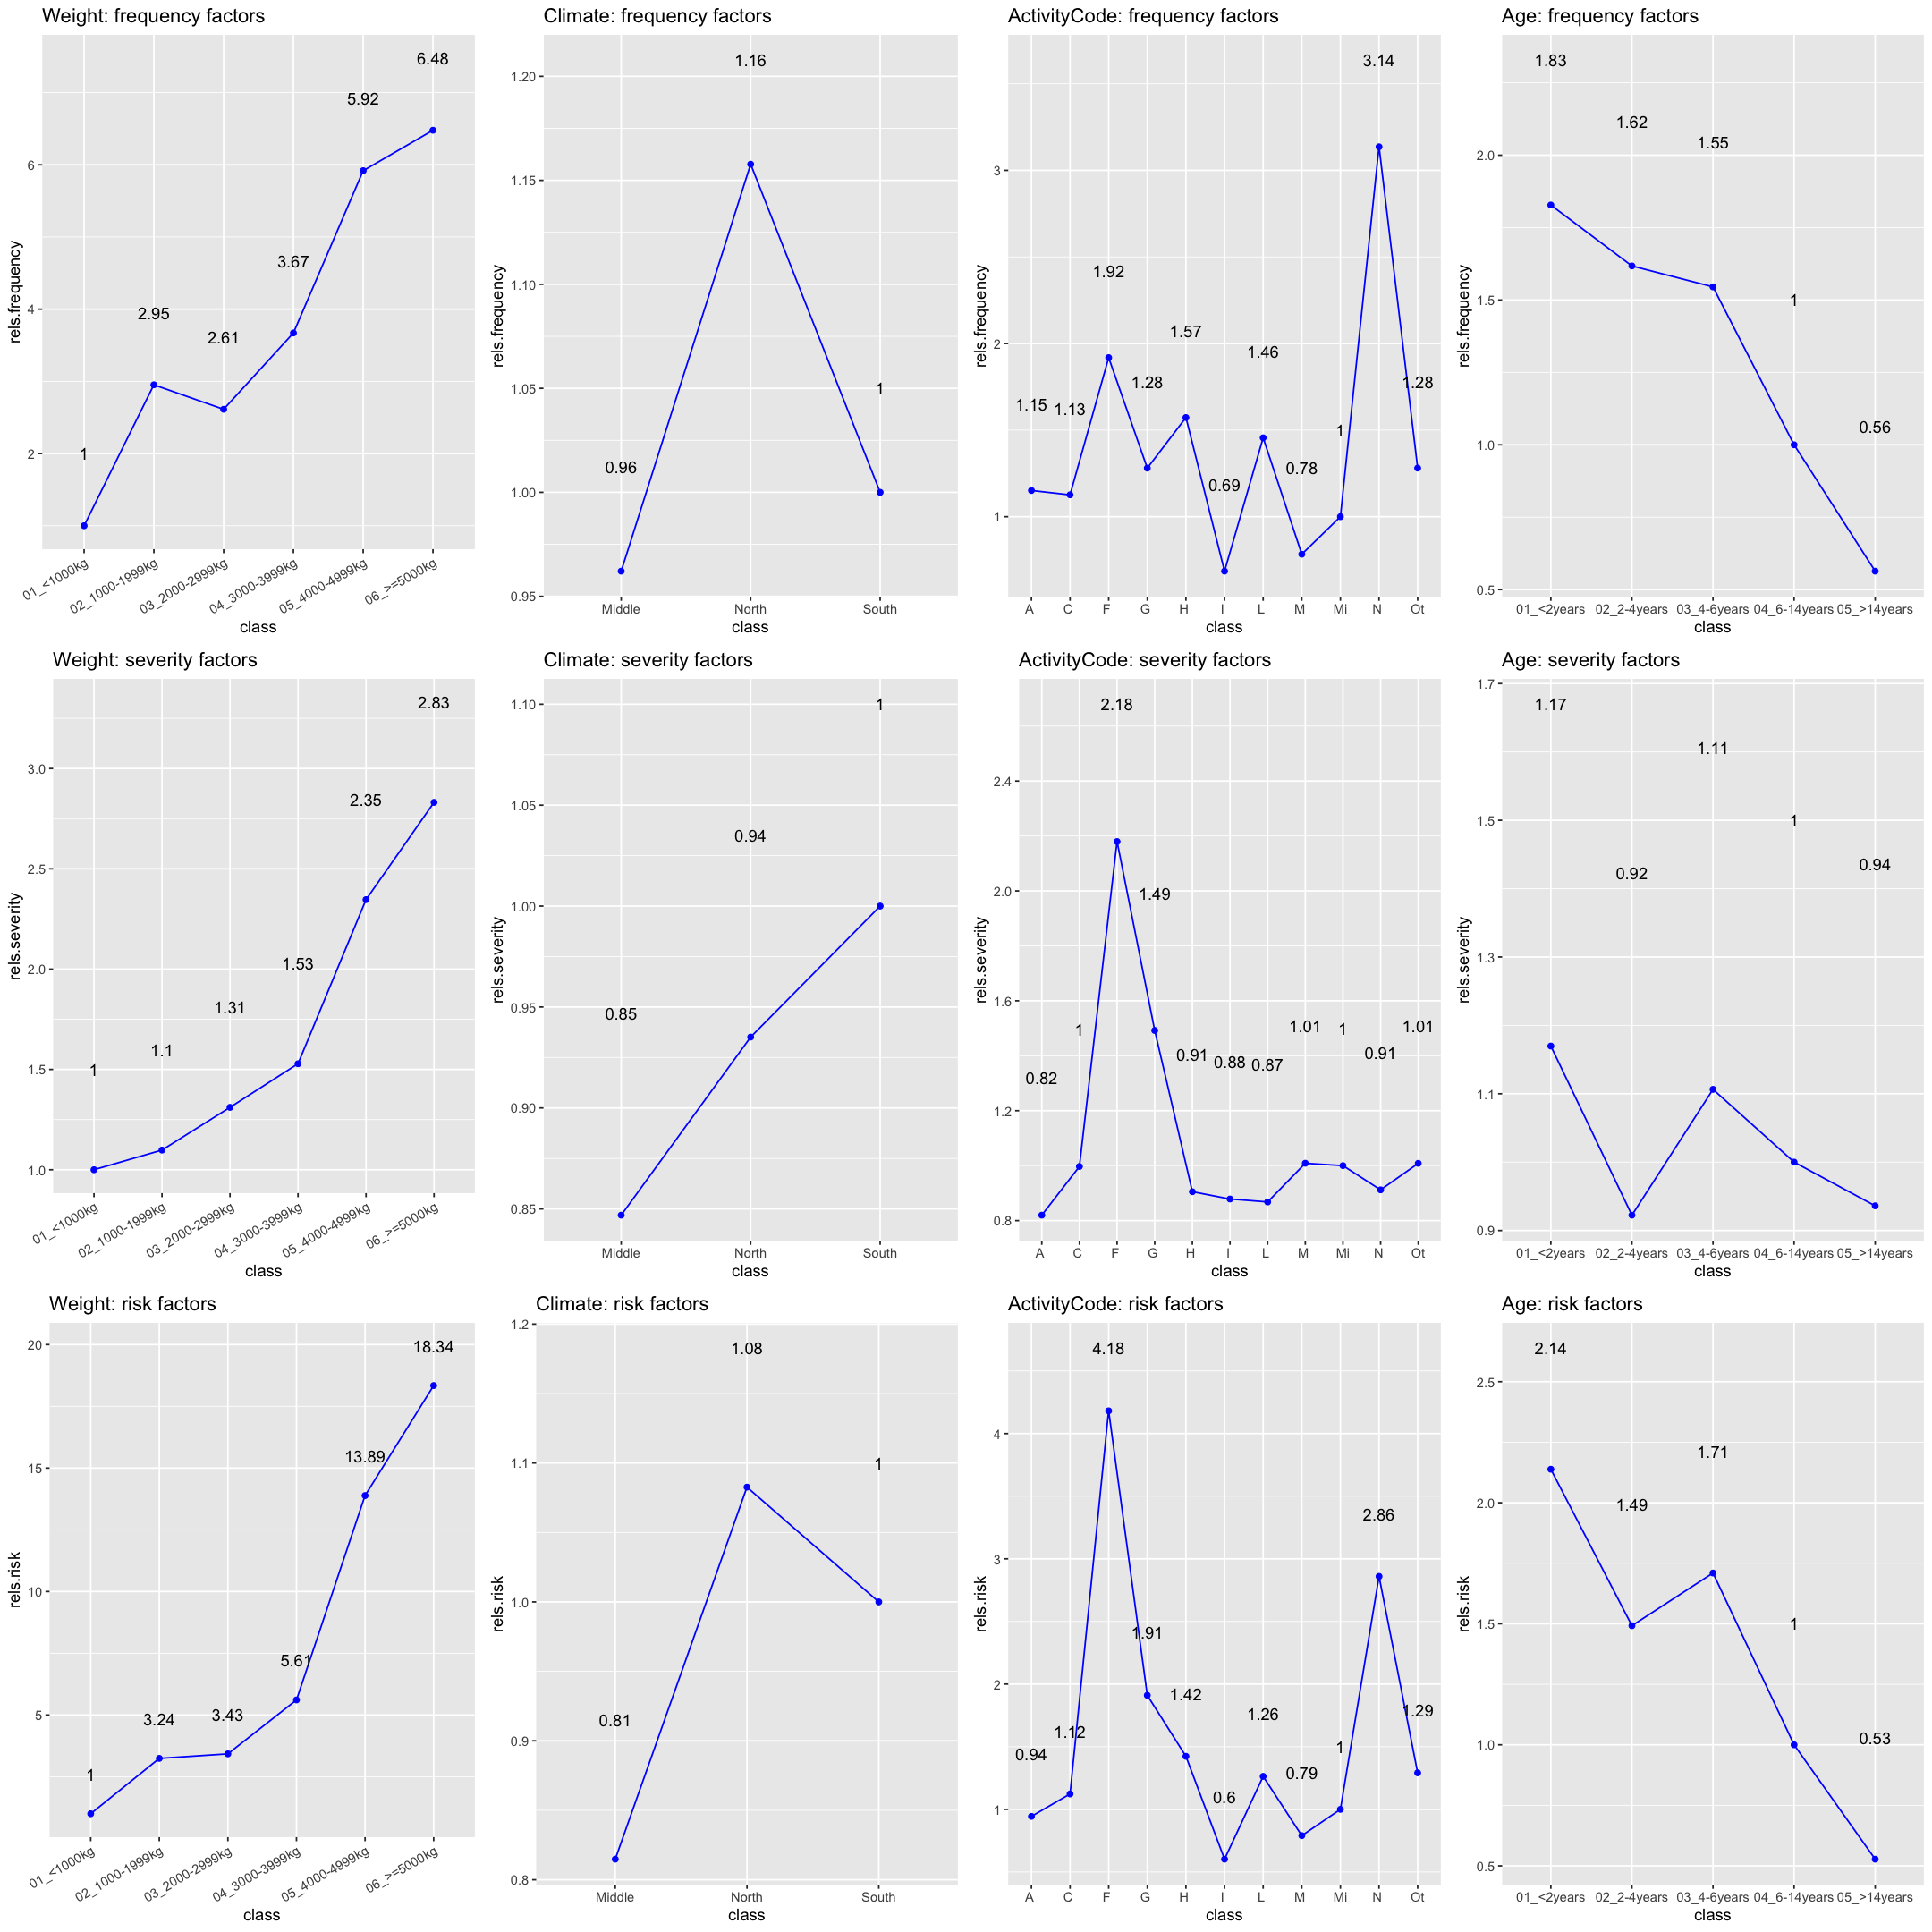

In [131]:
######################### Section 4: Plotting #########################

# In this section, the results from the GLM are plotted.

# First, long variable names need to be cut, to fit into the plots.
# This row of code cuts away everything except for the first letter for variable names belonging to activity codes.
##### If you have long variable names, modify here to cut them.
# this is a bad thing to do since we just mixed Missing and Class M- Education
glmdata3[glmdata3$rating.factor == "ActivityCode",2] <- substr(glmdata3$class,1,2)[10:20]  


# Then the results are plotted. This code plots the GLM factors for frequency, severity, and total risk, for the three variables Weight, Climate, and Activity code.
##### If you have changed what variables are included in your model, add, remove, or modify sections of this code to plot them. 
##### This is also where you can make changes to change the look of your plots, if you would like to.

p1 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.frequency)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: frequency factors") +
      geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=1) +theme(axis.text.x = element_text(angle = 30, hjust = 1))

p2 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.severity)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: severity factors") +
      geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)+theme(axis.text.x = element_text(angle = 30, hjust = 1))

p3 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.risk)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: risk factors") +
      geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=1.6)+theme(axis.text.x = element_text(angle = 30, hjust = 1))

p4 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.05)

p5 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.1)

p6 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.1)

p7 <- ggplot(subset(glmdata3, rating.factor=="ActivityCode"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.5) 

p8 <- ggplot(subset(glmdata3, rating.factor=="ActivityCode"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)

p9 <- ggplot(subset(glmdata3, rating.factor=="ActivityCode"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.5)

p10 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.5) 

p11 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)

p12 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.5)


options(repr.plot.width=18, repr.plot.height=18)
multiplot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12, cols=4)


In the above plots we see the risk factors (vertical axis) for each category (horizontal axis) using the claim frequency data on the top row, claim severity data in the second row and their product, used to get the final risk factor in the lowest row

This graph gives a lot of information on how to efficiently group the factors, since we want to group them such that the risk factors are fairly similar. 

We combine the knowledge from these plots with the summary statistics from the claims frequency and claims severity to further refine the grouping.

Key points
1. Weight groups could be divided further as each group have quite different risk factors, however we should not divide them such that the duration decreases too much
2. Claim severity is only high for classes $F$, $G$ with respect ot Activity code, but the frequency is relatively high $N$. These differences produce a final risk factor from which we could consider grouping $C$, $L$ and $Ot$ which has a final risk factor of 1.2,1.29 and 1.27 respectively. But, $Ot$ refers to Other which may contain a multitude of different activities, thus we mix $C$ and $L$ into one group.
3. $MI$ and $A$ have risk factors of 1 and 0.94 respectively however $MI$ refer to the missing value points thus mixing them with a known class causes us to lose information.
3. Surprisingly (for me atleast) the risk factor decreases as the tractor gets older.

Based on this analysis we consider applying the grouping recommended 

After doing the above grouping we see that classes $A$ and $M$ for Activity Code have risk factors of 1.29 and 1.28 respectively, thus we group them together.

In [140]:
#We group the activity code and do the whole GLM analysis again to get the new plots and summary statistics

# this solution is so ugly it shames me to my core
h factors

glmdata2 <- aggregate(glmdata[,6:8],by=list(weight_group = glmdata$weight_group, 
                                            Climate = glmdata$Climate,
                                            activity_group = glmdata$activity_group,
                                            age_group = glmdata$age_group), FUN=sum, na.rm=TRUE)



# here again we modified ActivityCode to activity_group
glmdata3 <-
  data.frame(rating.factor =
               c(rep("Weight", nlevels(glmdata2$weight_group)),
                 rep("Climate", nlevels(glmdata2$Climate)),
                 rep("activity_group", nlevels(glmdata2$activity_group)),
                 rep("Age", nlevels(glmdata2$age_group))),
             class =
               c(levels(glmdata2$weight_group),
                 levels(glmdata2$Climate),
                 levels(glmdata2$activity_group),
                 levels(glmdata2$age_group)),
             stringsAsFactors = FALSE)

new.cols <-
  foreach (rating.factor = c("weight_group", "Climate", "activity_group", "age_group"),
           .combine = rbind) %do%
           {
             nclaims <- tapply(glmdata2$NoOfClaims, glmdata2[[rating.factor]], sum)
             sums <- tapply(glmdata2$Duration, glmdata2[[rating.factor]], sum)
             n.levels <- nlevels(glmdata2[[rating.factor]]) #removing this line gives subscript out of bounds error
             contrasts(glmdata2[[rating.factor]]) <-
              contr.treatment(n.levels)[rank(-sums, ties.method = "first"), ]
             data.frame(duration = sums, n.claims = nclaims)
           }

glmdata3 <- cbind(glmdata3, new.cols)
rm(new.cols)

######################### Section 3: GLM analysis #########################

# Now we get to the fun part - the GLM analysis. It is performed using R's built in GLM function 

# First, we model the claims frequency. 
# The first part of this performs a GLM analysis, with glmdata2 as the data source modelling NoOfClaims, 
# by the Duration. It looks at three variables: weight_group, Climate, and ActivityCode.
##### This is where you can modify the model by adding or removing variables 

model.frequency <-
  glm(NoOfClaims ~ weight_group + Climate + activity_group + age_group + offset(log(Duration)),
      data = glmdata2, family = poisson)

# Then we save the coefficients resulting from the GLM analysis in an array
##### You should not need to modify this part of the code

rels <- coef(model.frequency)
rels <- exp(rels[1] + rels[-1])/exp(rels[1])
#rels[1] is the intercept, rels[-1] is everything besides the intercept
# above we get the actual factors 

# Finally, we attach the coefficients to the already prepared table glmdata3, in a column named rels.frequency
# There is no good way of doing this automatically, so we need to do some manual tricks
# This code creates a vector with 6 positions consisting of the integer 1, and then positions number 1-5 
# in the rels array. Then it attaches this to rows 1-6 of glmdata3, sorted from highest to lowest duration, 
# since the GLM data is on this form. In other words, the code takes the GLM coeffisients for the six weight 
# groups and saves those in glmdata3, in the rows corresponding to those groups.
# After that, it does the same thing for the rest of the GLM coefficients, belonging to climate 
# and activity code vairables.
##### You need to modify this code to suit your set of variables and groups, to make sure each 
# GLM coefficient is saved in the correct place.

# nlevels(glmdata2[["weight_group"]]) returns 6 becauses theres 6 levels to the weight factor

##### You need to modify this code
variableLevels <- c(nlevels(glmdata2[["weight_group"]]),
                 nlevels(glmdata2[["Climate"]]),
                 nlevels(glmdata2[["activity_group"]]),
                 nlevels(glmdata2[["age_group"]]))

#You do not need to modify this part
cs <- cumsum(variableLevels)
cs_rels <- cs
for(i in 1:length(variableLevels)){
  cs_rels[i] <- cs[i]-i
}

# The following code needs to be used at two different places so we put it in a function.
##### This part needs to be modified if you change which variables are included in the model, 
# but not if you change the groups inside a variable
attachRels <- function(rels_vec, vector, cs, cs_rels) {
  c(c(1, rels_vec[ 1 : cs_rels[1] ])[rank(-vector[ 1 : cs[1] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[1]+1) : cs_rels[2] ])[rank(-vector[ (cs[1]+1) : cs[2] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[2]+1) : cs_rels[3] ])[rank(-vector[ (cs[2]+1) : cs[3] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[3]+1) : cs_rels[4] ])[rank(-vector[ (cs[3]+1) : cs[4] ], ties.method = "first")])
}

# Use the function created above, you do not need to modify this part
glmdata3$rels.frequency <- attachRels(rels, glmdata3$duration, cs, cs_rels)



########################
# We then do the same thing again, now modelling severity instead of claim frequency.
# That means that, in this part, we want to look at the average claim. So first, we calculate the 
# average claim for each row in glmdata2
##### You should not need to change anything in this piece of code.

glmdata2$avgclaim=glmdata2$ClaimCost/glmdata2$NoOfClaims

# Then we do the same thing as we did when modelling claims frequency, but we look at average claim;
# A GLM analysis is run, the coefficients stored, and saved in a new column, named rels.severity, glmdata3
##### You need to modify this part of the code in the same way as you did for the GLM model for frequency.  
# Add or remove variables
##### Remember that, according to the project instructions, you need to use the same variables for the 
# severity as for the frequency.

# converting nan to 0 from average claims
is.nan.data.frame <- function(x)
do.call(cbind, lapply(x, is.nan))
glmdata2$avgclaim[is.nan(glmdata2$avgclaim)]<-0

model.severity <-
  glm(avgclaim ~ weight_group + Climate + activity_group + age_group ,
      data = glmdata2[glmdata2$avgclaim>0,], family = Gamma("log"), weight=NoOfClaims)

# You do not need to change this part
rels <- coef(model.severity)
rels <- exp( rels[1] + rels[-1] ) / exp( rels[1] )
glmdata3$rels.severity <- attachRels(rels, glmdata3$duration, cs, cs_rels)

# Finally, the final risk factor is calculated, as the product of the frequency and severity factors. 
##### You should not have to modify this coed.
##### Congratulations! You now have a model for the risk!
glmdata3$rels.risk <- with(glmdata3, rels.frequency*rels.severity)


In [141]:
summary(model.frequency)
summary(model.severity)


Call:
glm(formula = NoOfClaims ~ weight_group + Climate + activity_group + 
    age_group + offset(log(Duration)), family = poisson, data = glmdata2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6026  -0.7800  -0.3786   0.2119   3.1521  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.02532    0.15026 -40.099  < 2e-16 ***
weight_group2     1.08375    0.15135   7.160 8.04e-13 ***
weight_group3     1.28931    0.16265   7.927 2.25e-15 ***
weight_group4     0.95590    0.21015   4.549 5.40e-06 ***
weight_group5     1.76810    0.16703  10.585  < 2e-16 ***
weight_group6     1.85251    0.16301  11.364  < 2e-16 ***
Climate2         -0.04499    0.10258  -0.439 0.660961    
Climate3          0.14576    0.12795   1.139 0.254653    
activity_group2   0.15076    0.13984   1.078 0.280982    
activity_group3   0.31886    0.15254   2.090 0.036584 *  
activity_group4   1.14877    0.15242   7.537 4.82e-14 ***
activity_group5   0.6637


Call:
glm(formula = avgclaim ~ weight_group + Climate + activity_group + 
    age_group, family = Gamma("log"), data = glmdata2[glmdata2$avgclaim > 
    0, ], weights = NoOfClaims)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1445  -0.6155  -0.1029   0.3548   2.9086  

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      10.02770    0.17097  58.652  < 2e-16 ***
weight_group2     0.06535    0.18242   0.358  0.72067    
weight_group3     0.39291    0.18627   2.109  0.03660 *  
weight_group4     0.22581    0.26402   0.855  0.39379    
weight_group5     0.83048    0.19177   4.331 2.73e-05 ***
weight_group6     0.97693    0.18598   5.253 5.12e-07 ***
Climate2         -0.19629    0.12383  -1.585  0.11506    
Climate3         -0.05820    0.14780  -0.394  0.69430    
activity_group2  -0.20020    0.14576  -1.374  0.17166    
activity_group3  -0.11079    0.17869  -0.620  0.53620    
activity_group4  -0.09158    0.18566  -0.493  0.622

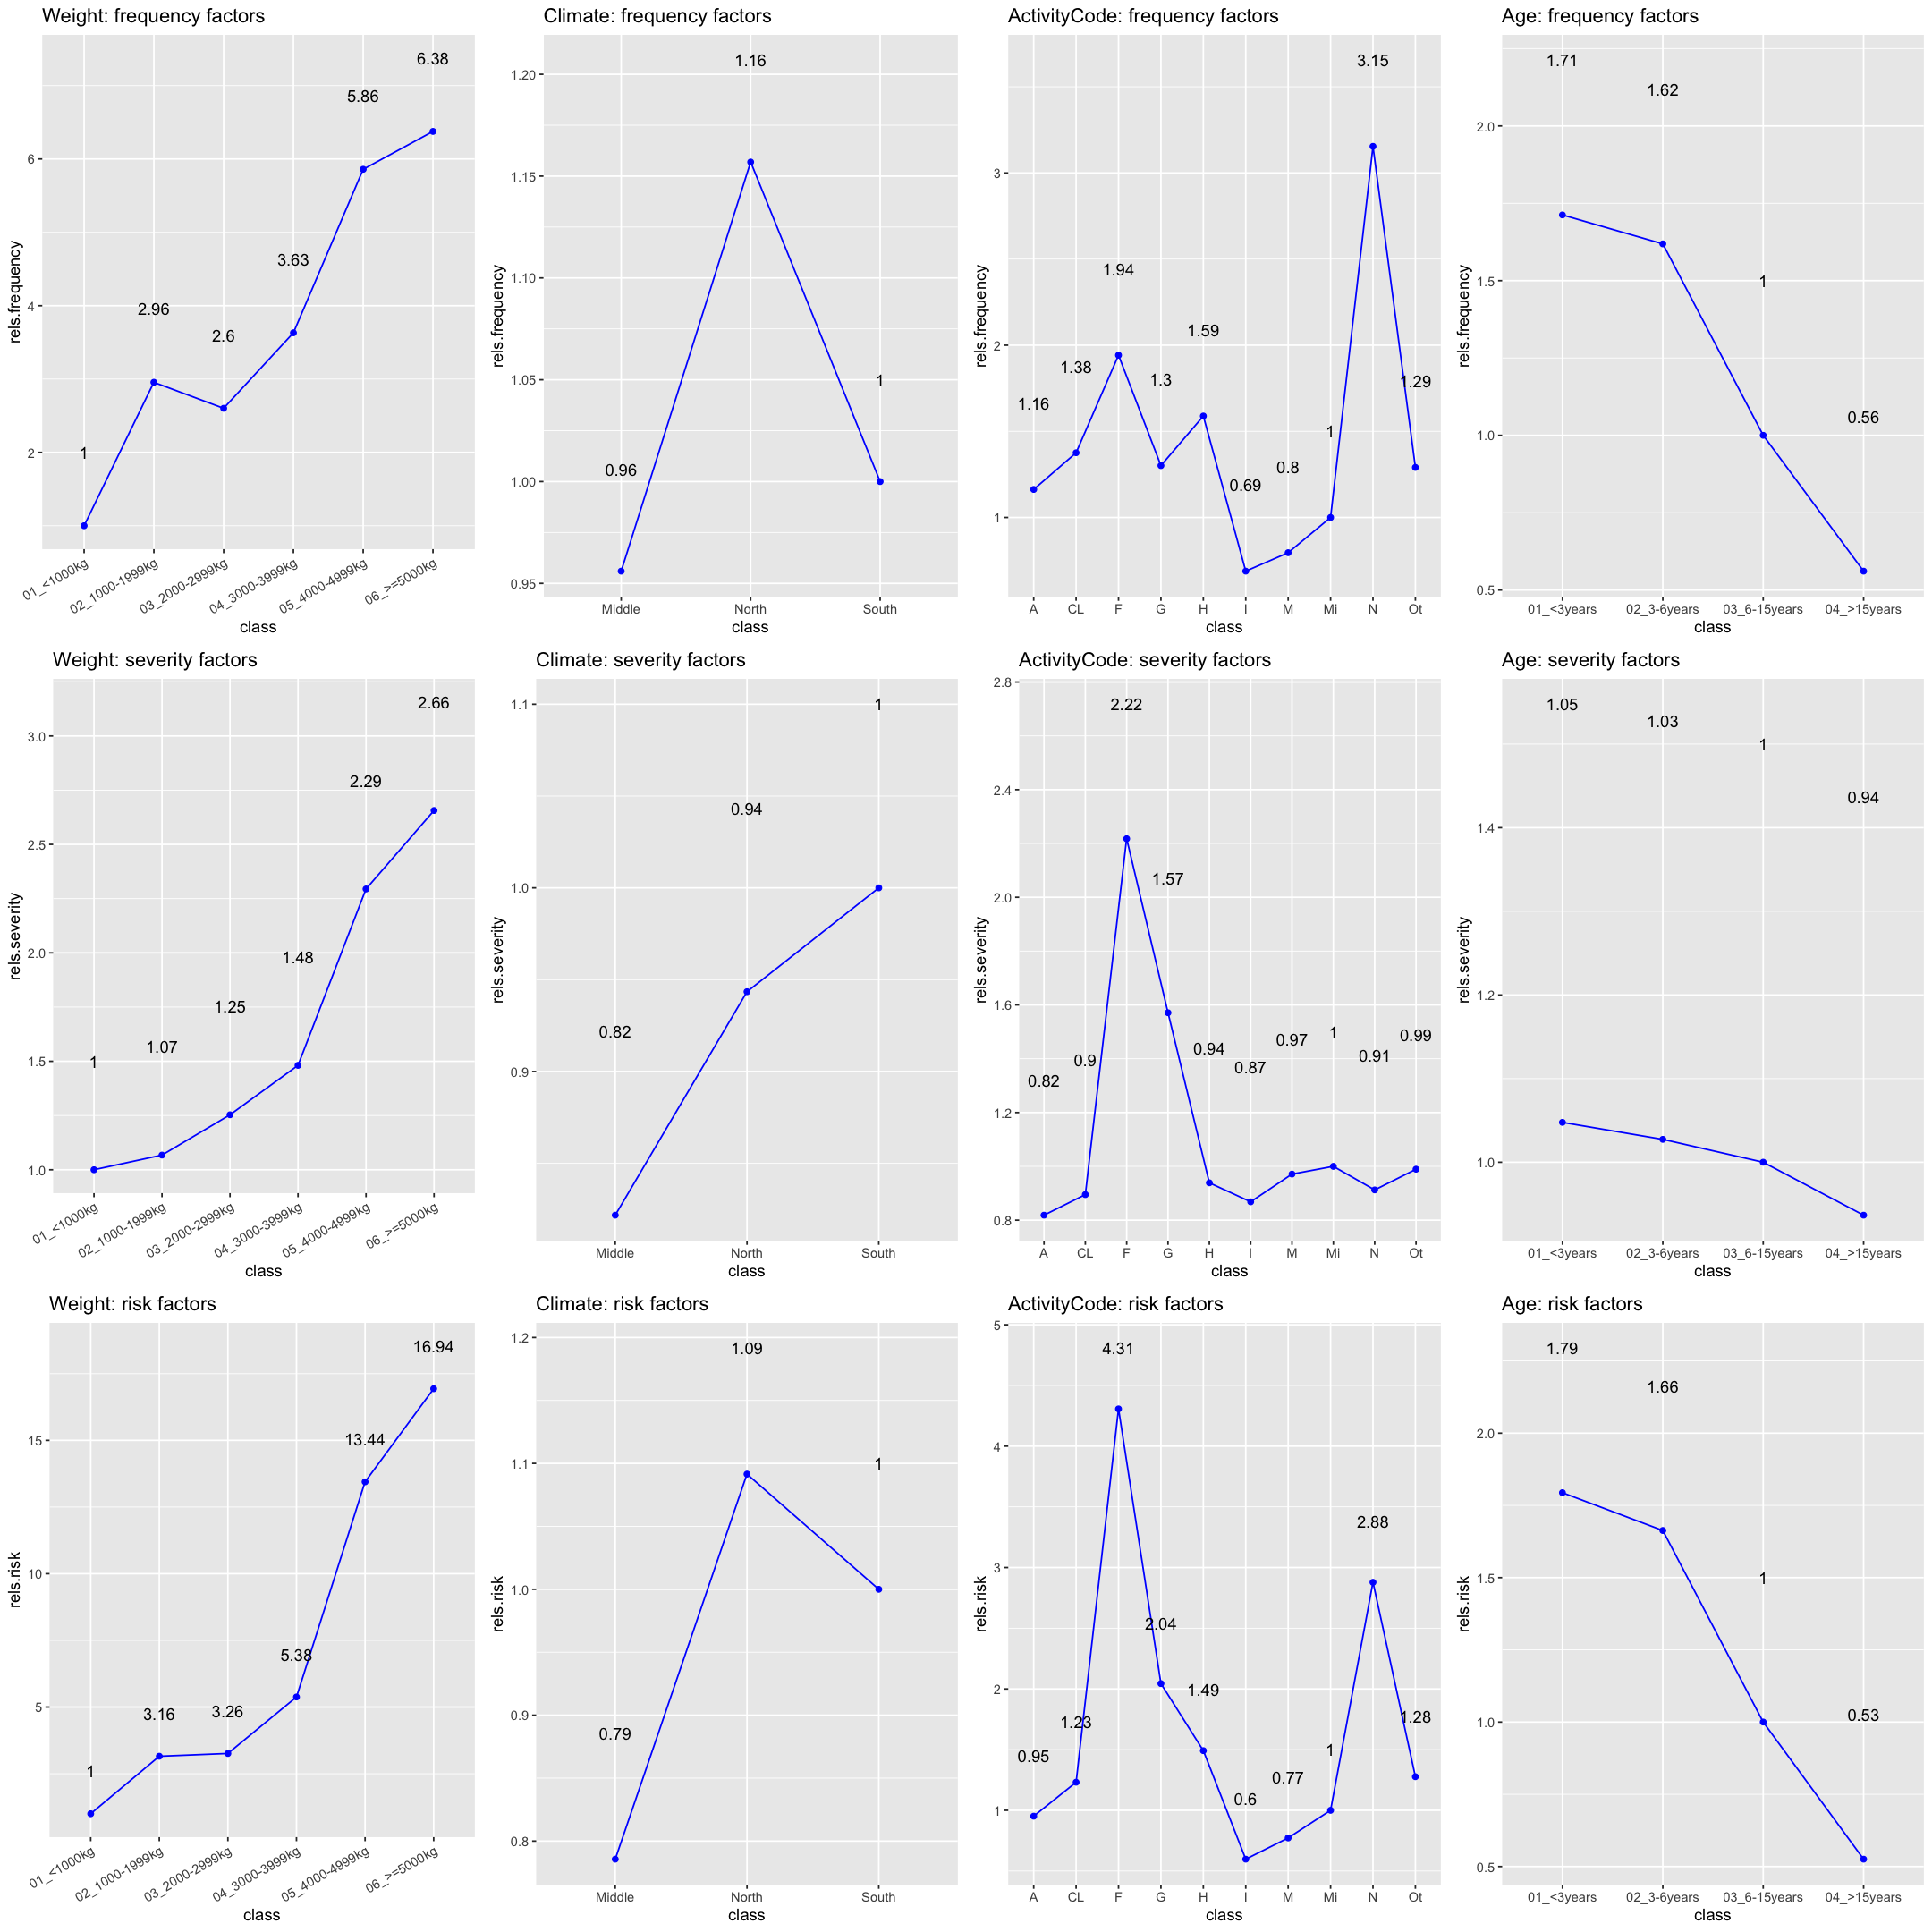

In [142]:
######################### Section 4: Plotting #########################

# In this section, the results from the GLM are plotted.

# First, long variable names need to be cut, to fit into the plots.
# This row of code cuts away everything except for the first letter for variable names belonging to activity codes.
##### If you have long variable names, modify here to cut them.
# this is a bad thing to do since we just mixed Missing and Class M- Education
glmdata3[glmdata3$rating.factor == "ActivityCode",2] <- substr(glmdata3$class,1,2)[11:20]  


# Then the results are plotted. This code plots the GLM factors for frequency, severity, and total risk, for the three variables Weight, Climate, and Activity code.
##### If you have changed what variables are included in your model, add, remove, or modify sections of this code to plot them. 
##### This is also where you can make changes to change the look of your plots, if you would like to.

p1 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.frequency)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: frequency factors") +
      geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=1) +theme(axis.text.x = element_text(angle = 30, hjust = 1))

p2 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.severity)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: severity factors") +
      geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)+theme(axis.text.x = element_text(angle = 30, hjust = 1))

p3 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.risk)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: risk factors") +
      geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=1.6)+theme(axis.text.x = element_text(angle = 30, hjust = 1))

p4 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.05)

p5 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.1)

p6 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.1)

p7 <- ggplot(subset(glmdata3, rating.factor=="activity_group"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.5) 

p8 <- ggplot(subset(glmdata3, rating.factor=="activity_group"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)

p9 <- ggplot(subset(glmdata3, rating.factor=="activity_group"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.5)

p10 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.5) 

p11 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)

p12 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.5)


options(repr.plot.width=18, repr.plot.height=18)
multiplot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12, cols=4)


Now we could try to further refine the intervals for weight and age. We can see that for the weight, the rate of increase of the risk factor increases as the weight increases. Thus it might be a good idea to divide the latter half of the domain into finer intervals to ensure a more smoother transition for the risk factor. Similarly for the age, the rate of decrease of the risk factor increases as the age increases thus we can aim to introduce an extra interval at the latter half of the age domain to account. But before splitting these groups even further we should look at the amount of the quantity of data per each group so that we can make sure we divide them in a manner that each group doesn't have too few data points. We can experiment with different ranges to see if we can divide them in a manner such that the data points are somewhat equally distributed between the groups we divide into

In [208]:

print("Weight group data")
table(glmdata$weight_group)
print("Vehicle age group data")
table(glmdata$age_group)

# possible split of first group in Weight class (divides 37898 into 20862 and 17036)
print("Weight <500")
sum(glmdata$Weight<500)
print("500<= Weight <1000")
sum(glmdata$Weight>=500 & glmdata$Weight<1000 )

# possible split of second group in Weight class (here, 1420 instead of 1400 divides 18482 into 9215 and 9267
# but we do not pursue this since we might not ge generalizing)
print("1000<= Weight <1400")
sum(glmdata$Weight>=1000 & glmdata$Weight<1400 )
print("1400<= Weight <2000")
sum(glmdata$Weight>=1400 & glmdata$Weight<2000 )

# Now we aim to divide the next 3 groups into 5 groups
print("3000<= Weight <3500")
sum(glmdata$Weight>=3000 & glmdata$Weight<3400)
print("3400<= Weight <3800")
sum(glmdata$Weight>=3400 & glmdata$Weight<3800)
print("3800<= Weight <4400")
sum(glmdata$Weight>=3800 & glmdata$Weight<4400)
print("4400<= Weight <5400")
sum(glmdata$Weight>=4400 & glmdata$Weight<5400)
print("Weight >=5400")
sum(glmdata$Weight>=5400 )

print("6<= VehicleAge<10")
sum(glmdata$VehicleAge>=6 & glmdata$VehicleAge<10 )
print("10<= VehicleAge<15")
sum(glmdata$VehicleAge>=10 & glmdata$VehicleAge<15 )
print("15<= VehicleAge<22")
sum(glmdata$VehicleAge>=15 & glmdata$VehicleAge<22 )
print("VehicleAge>=22")
sum(glmdata$VehicleAge>=22)

[1] "Weight group data"



    01_<1000kg 02_1000-1999kg 03_2000-2999kg 04_3000-3999kg 05_4000-4999kg 
         37898          18482           8968          16093           8642 
   06_>=5000kg 
          8991 

[1] "Vehicle age group data"



  01_<3years  02_3-6years 03_6-15years  04_>15years 
       17448        17227        33305        31094 

[1] "Weight <500"


[1] 20862

[1] "500<= Weight <1000"


[1] 17036

[1] "1000<= Weight <1400"


[1] 8515

[1] "1400<= Weight <2000"


[1] 9967

[1] "3000<= Weight <3500"


[1] 6043

[1] "3400<= Weight <3800"


[1] 7114

[1] "3800<= Weight <4400"


[1] 6963

[1] "4400<= Weight <5400"


[1] 6431

[1] "Weight >=5400"


[1] 7175

[1] "6<= VehicleAge<10"


[1] 19093

[1] "10<= VehicleAge<15"


[1] 14212

[1] "15<= VehicleAge<22"


[1] 13819

[1] "VehicleAge>=22"


[1] 17275

After a lot of experimentation we choose the above grouping to divide those factors even further, the main heuristic behind this is that we aimed to have as much similar numbers within each group as possible. 

In [219]:
# We divide the groups as we looked above and do the whole GLM
# I should really abstract this process

glmdata$weight_group <- cut(glmdata$Weight, 
                       breaks = c(-Inf, 1000, 3000, 3400, 3800, 4400, 5400, Inf), 
                       labels = c("01_<1000kg", "02_1000-2999kg", "03_3000-3399kg", "04_3400-3799kg","05_3800-4400kg", "06_4400-5400kg", "07_>=5400kg"), 
                       right = FALSE)

glmdata$age_group <- cut(glmdata$VehicleAge, 
                            breaks = c(-Inf, 3, 6, 10, 15, 22, Inf), 
                            labels = c("01_<3years", "02_3-6years","03_6-10years","04_10-15years", "05_15-22years", "06_>22years"), 
                            right = FALSE)

glmdata2 <- aggregate(glmdata[,6:8],by=list(weight_group = glmdata$weight_group, 
                                            Climate = glmdata$Climate,
                                            activity_group = glmdata$activity_group,
                                            age_group = glmdata$age_group), FUN=sum, na.rm=TRUE)



# here again we modified ActivityCode to activity_group
glmdata3 <-
  data.frame(rating.factor =
               c(rep("Weight", nlevels(glmdata2$weight_group)),
                 rep("Climate", nlevels(glmdata2$Climate)),
                 rep("activity_group", nlevels(glmdata2$activity_group)),
                 rep("Age", nlevels(glmdata2$age_group))),
             class =
               c(levels(glmdata2$weight_group),
                 levels(glmdata2$Climate),
                 levels(glmdata2$activity_group),
                 levels(glmdata2$age_group)),
             stringsAsFactors = FALSE)

new.cols <-
  foreach (rating.factor = c("weight_group", "Climate", "activity_group", "age_group"),
           .combine = rbind) %do%
           {
             nclaims <- tapply(glmdata2$NoOfClaims, glmdata2[[rating.factor]], sum)
             sums <- tapply(glmdata2$Duration, glmdata2[[rating.factor]], sum)
             n.levels <- nlevels(glmdata2[[rating.factor]]) #removing this line gives subscript out of bounds error
             contrasts(glmdata2[[rating.factor]]) <-
              contr.treatment(n.levels)[rank(-sums, ties.method = "first"), ]
             data.frame(duration = sums, n.claims = nclaims)
           }

glmdata3 <- cbind(glmdata3, new.cols)
rm(new.cols)

######################### Section 3: GLM analysis #########################

# Now we get to the fun part - the GLM analysis. It is performed using R's built in GLM function 

# First, we model the claims frequency. 
# The first part of this performs a GLM analysis, with glmdata2 as the data source modelling NoOfClaims, 
# by the Duration. It looks at three variables: weight_group, Climate, and ActivityCode.
##### This is where you can modify the model by adding or removing variables 

model.frequency <-
  glm(NoOfClaims ~ weight_group + Climate + activity_group + age_group + offset(log(Duration)),
      data = glmdata2, family = poisson)

# Then we save the coefficients resulting from the GLM analysis in an array
##### You should not need to modify this part of the code

rels <- coef(model.frequency)
rels <- exp(rels[1] + rels[-1])/exp(rels[1])
#rels[1] is the intercept, rels[-1] is everything besides the intercept
# above we get the actual factors 

# Finally, we attach the coefficients to the already prepared table glmdata3, in a column named rels.frequency
# There is no good way of doing this automatically, so we need to do some manual tricks
# This code creates a vector with 6 positions consisting of the integer 1, and then positions number 1-5 
# in the rels array. Then it attaches this to rows 1-6 of glmdata3, sorted from highest to lowest duration, 
# since the GLM data is on this form. In other words, the code takes the GLM coeffisients for the six weight 
# groups and saves those in glmdata3, in the rows corresponding to those groups.
# After that, it does the same thing for the rest of the GLM coefficients, belonging to climate 
# and activity code vairables.
##### You need to modify this code to suit your set of variables and groups, to make sure each 
# GLM coefficient is saved in the correct place.

# nlevels(glmdata2[["weight_group"]]) returns 6 becauses theres 6 levels to the weight factor

##### You need to modify this code
variableLevels <- c(nlevels(glmdata2[["weight_group"]]),
                 nlevels(glmdata2[["Climate"]]),
                 nlevels(glmdata2[["activity_group"]]),
                 nlevels(glmdata2[["age_group"]]))

#You do not need to modify this part
cs <- cumsum(variableLevels)
cs_rels <- cs
for(i in 1:length(variableLevels)){
  cs_rels[i] <- cs[i]-i
}

# The following code needs to be used at two different places so we put it in a function.
##### This part needs to be modified if you change which variables are included in the model, 
# but not if you change the groups inside a variable
attachRels <- function(rels_vec, vector, cs, cs_rels) {
  c(c(1, rels_vec[ 1 : cs_rels[1] ])[rank(-vector[ 1 : cs[1] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[1]+1) : cs_rels[2] ])[rank(-vector[ (cs[1]+1) : cs[2] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[2]+1) : cs_rels[3] ])[rank(-vector[ (cs[2]+1) : cs[3] ], ties.method = "first")],
    c(1, rels_vec[ (cs_rels[3]+1) : cs_rels[4] ])[rank(-vector[ (cs[3]+1) : cs[4] ], ties.method = "first")])
}

# Use the function created above, you do not need to modify this part
glmdata3$rels.frequency <- attachRels(rels, glmdata3$duration, cs, cs_rels)



########################
# We then do the same thing again, now modelling severity instead of claim frequency.
# That means that, in this part, we want to look at the average claim. So first, we calculate the 
# average claim for each row in glmdata2
##### You should not need to change anything in this piece of code.

glmdata2$avgclaim=glmdata2$ClaimCost/glmdata2$NoOfClaims

# Then we do the same thing as we did when modelling claims frequency, but we look at average claim;
# A GLM analysis is run, the coefficients stored, and saved in a new column, named rels.severity, glmdata3
##### You need to modify this part of the code in the same way as you did for the GLM model for frequency.  
# Add or remove variables
##### Remember that, according to the project instructions, you need to use the same variables for the 
# severity as for the frequency.

# converting nan to 0 from average claims
is.nan.data.frame <- function(x)
do.call(cbind, lapply(x, is.nan))
glmdata2$avgclaim[is.nan(glmdata2$avgclaim)]<-0

model.severity <-
  glm(avgclaim ~ weight_group + Climate + activity_group + age_group ,
      data = glmdata2[glmdata2$avgclaim>0,], family = Gamma("log"), weight=NoOfClaims)

# You do not need to change this part
rels <- coef(model.severity)
rels <- exp( rels[1] + rels[-1] ) / exp( rels[1] )
glmdata3$rels.severity <- attachRels(rels, glmdata3$duration, cs, cs_rels)

# Finally, the final risk factor is calculated, as the product of the frequency and severity factors. 
##### You should not have to modify this coed.
##### Congratulations! You now have a model for the risk!
glmdata3$rels.risk <- with(glmdata3, rels.frequency*rels.severity)


In [220]:
summary(model.frequency)
summary(model.severity)


Call:
glm(formula = NoOfClaims ~ weight_group + Climate + activity_group + 
    age_group + offset(log(Duration)), family = poisson, data = glmdata2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3691  -0.6632  -0.3658  -0.1066   3.7436  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.92446    0.16173 -36.632  < 2e-16 ***
weight_group2     1.09005    0.14367   7.587 3.27e-14 ***
weight_group3     1.27207    0.19373   6.566 5.16e-11 ***
weight_group4     1.75732    0.18441   9.529  < 2e-16 ***
weight_group5     1.88777    0.17436  10.827  < 2e-16 ***
weight_group6     1.72700    0.17372   9.941  < 2e-16 ***
weight_group7     1.24962    0.22270   5.611 2.01e-08 ***
Climate2         -0.03806    0.10268  -0.371 0.710920    
Climate3          0.14188    0.12799   1.109 0.267632    
activity_group2   0.16353    0.13999   1.168 0.242756    
activity_group3   0.30599    0.15259   2.005 0.044930 *  
activity_group4   1.1366


Call:
glm(formula = avgclaim ~ weight_group + Climate + activity_group + 
    age_group, family = Gamma("log"), data = glmdata2[glmdata2$avgclaim > 
    0, ], weights = NoOfClaims)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0586  -0.5046  -0.1436   0.3357   2.3334  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      10.130074   0.169579  59.737  < 2e-16 ***
weight_group2    -0.004378   0.154359  -0.028  0.97740    
weight_group3     0.541582   0.216976   2.496  0.01349 *  
weight_group4     0.801204   0.193053   4.150 5.19e-05 ***
weight_group5     0.999123   0.180147   5.546 1.07e-07 ***
weight_group6     0.950071   0.184900   5.138 7.39e-07 ***
weight_group7     0.438060   0.227556   1.925  0.05585 .  
Climate2         -0.254022   0.111981  -2.268  0.02453 *  
Climate3         -0.096075   0.135768  -0.708  0.48012    
activity_group2  -0.149435   0.137427  -1.087  0.27837    
activity_group3  -0.089035   0.159137  -

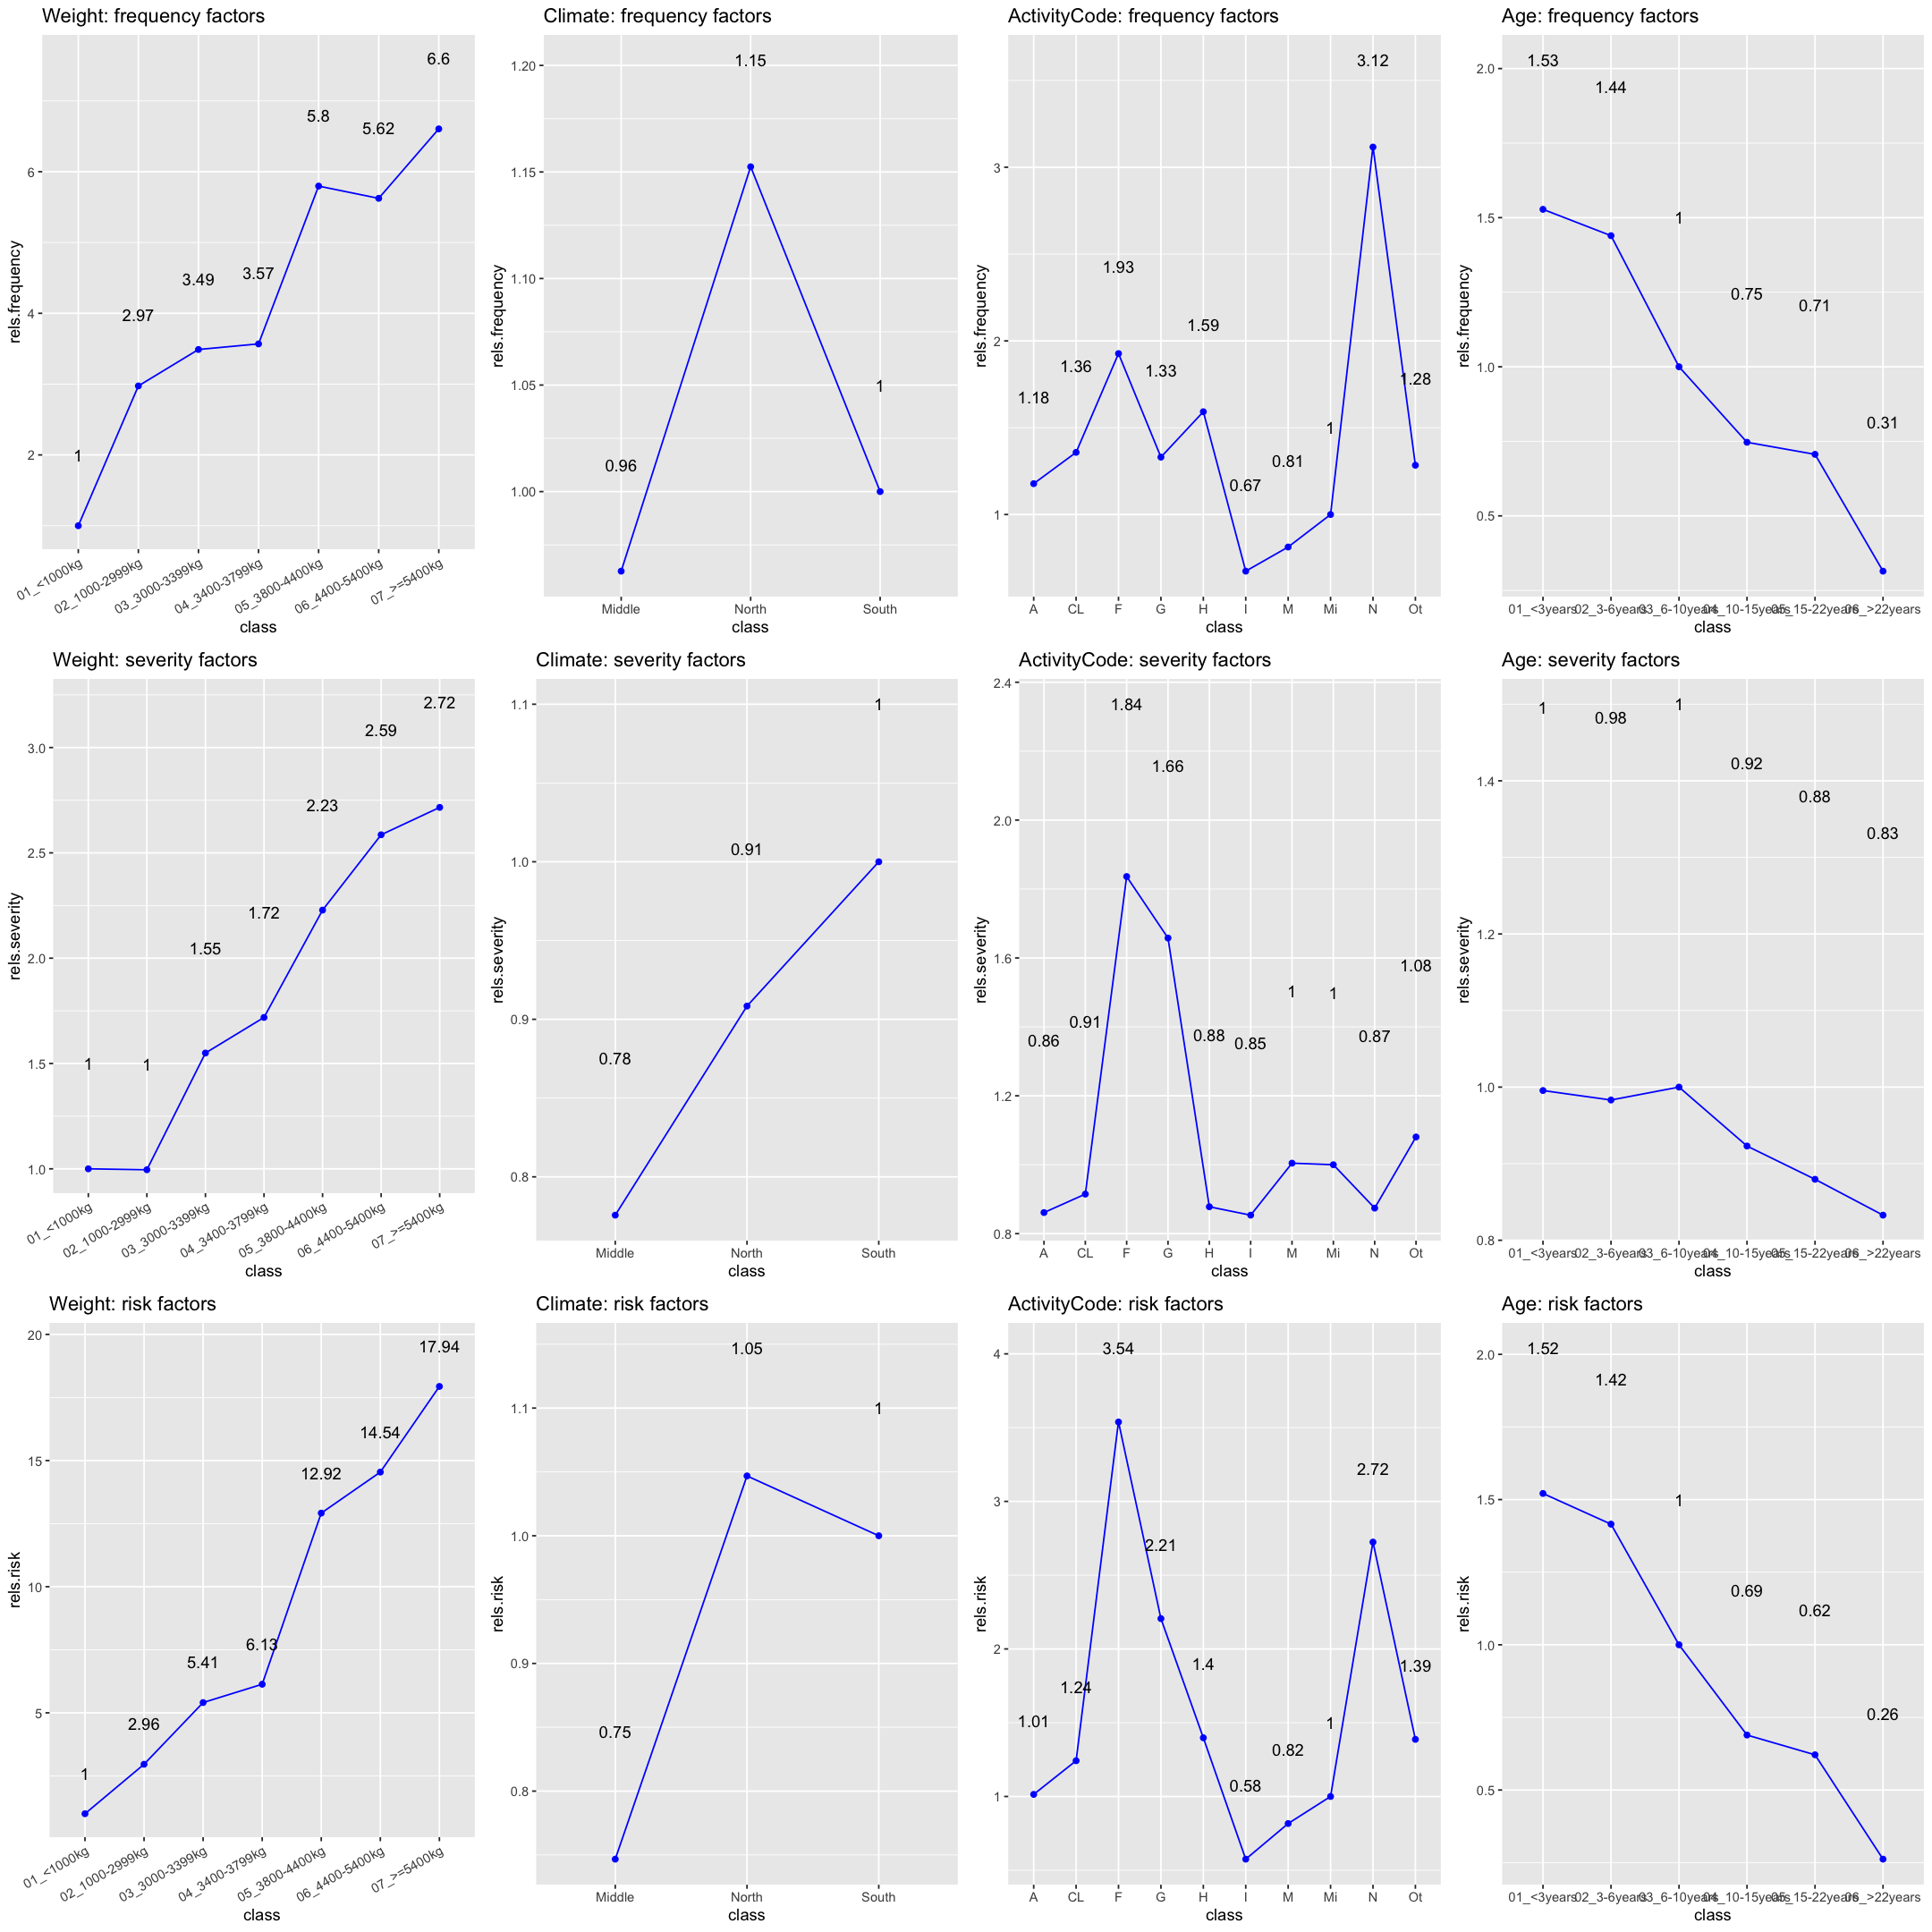

In [221]:
######################### Section 4: Plotting #########################

# In this section, the results from the GLM are plotted.

# First, long variable names need to be cut, to fit into the plots.
# This row of code cuts away everything except for the first letter for variable names belonging to activity codes.
##### If you have long variable names, modify here to cut them.
# this is a bad thing to do since we just mixed Missing and Class M- Education
glmdata3[glmdata3$rating.factor == "ActivityCode",2] <- substr(glmdata3$class,1,2)[11:20]  


# Then the results are plotted. This code plots the GLM factors for frequency, severity, and total risk, for the three variables Weight, Climate, and Activity code.
##### If you have changed what variables are included in your model, add, remove, or modify sections of this code to plot them. 
##### This is also where you can make changes to change the look of your plots, if you would like to.

p1 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.frequency)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: frequency factors") +
      geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=1) +theme(axis.text.x = element_text(angle = 30, hjust = 1))

p2 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.severity)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: severity factors") +
      geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)+theme(axis.text.x = element_text(angle = 30, hjust = 1))

p3 <- ggplot(subset(glmdata3, rating.factor=="Weight"), aes(x=class, y=rels.risk)) + 
      geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Weight: risk factors") +
      geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=1.6)+theme(axis.text.x = element_text(angle = 30, hjust = 1))

p4 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.05)

p5 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.1)

p6 <- ggplot(subset(glmdata3, rating.factor=="Climate"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Climate: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.1)

p7 <- ggplot(subset(glmdata3, rating.factor=="activity_group"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.5) 

p8 <- ggplot(subset(glmdata3, rating.factor=="activity_group"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)

p9 <- ggplot(subset(glmdata3, rating.factor=="activity_group"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("ActivityCode: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.5)

p10 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.frequency)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: frequency factors") +
  geom_text(aes(label=paste(round(rels.frequency,2))), nudge_y=0.5) 

p11 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.severity)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: severity factors") +
  geom_text(aes(label=paste(round(rels.severity,2))), nudge_y=0.5)

p12 <- ggplot(subset(glmdata3, rating.factor=="Age"), aes(x=class, y=rels.risk)) + 
  geom_point(colour="blue") + geom_line(aes(group=1), colour="blue") + ggtitle("Age: risk factors") +
  geom_text(aes(label=paste(round(rels.risk,2))), nudge_y=0.5)


options(repr.plot.width=18, repr.plot.height=18)
multiplot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12, cols=4)


When we did the actual split as mentioned above, we get a very huge bump for the risk factor second weight group, giving it 20.22 compared to 1 for the next lower group and 1.31 for the next higher group. The significance tests also had a relatively high p value (0.8) for the claim frequency model, indicating that the split gave a coefficient which was not significant enough. So we went back and merged the <500 and 500<=Weight<1000 groups into one, and reran the model to get the above values you see. We then noticed that !!!!

We are now quite satisfied with the groupings, and we thus now move on to setting the base parameter. To do this, we first want to single out the insurances in 2016 which started the previous year, so that we only have insurances which are currently active.

In [301]:
# In this cell we aim to extract the table of current customers
glmdata_15 <- glmdata[glmdata$RiskYear==2015, ]
glmdata_16 <- glmdata[glmdata$RiskYear==2016, ]

glmdata_15$Duration <- 1-glmdata_15$Duration
current_customers <- rbind(glmdata_15, glmdata_16) #merging rows of 2015 and 2016
# after deducting 1 from the duration, if they match in 2015 and 2016 then their insurance has ended during 2016
# we single out unique ids, this means everything matches, specifically their durations
unique_ids <- unique(c(current_customers[,2], current_customers[,3], current_customers[,4], current_customers[,5],current_customers[,6]))
# we remove those unique ids from our 2016 list
current_customers <- glmdata_16[-unique_ids,]
nrow(current_customers)
current_customers


[1] 8177

,RiskYear,VehicleAge,Weight,Climate,ActivityCode,Duration,NoOfClaims,ClaimCost,weight_group,age_group,activity_group
,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>
89962,2016,14,1320,Middle,L - Public administration and defence; compulsory social security,0.6126337,0,0,02_1000-2999kg,04_10-15years,CL
89963,2016,17,179,South,L - Public administration and defence; compulsory social security,0.5697533,0,0,01_<1000kg,05_15-22years,CL
89964,2016,18,179,South,L - Public administration and defence; compulsory social security,0.5744733,0,0,01_<1000kg,05_15-22years,CL
89965,2016,24,3410,Middle,Missing,0.5512419,0,0,04_3400-3799kg,06_>22years,Mi
89966,2016,25,3410,Middle,Missing,0.5150549,0,0,04_3400-3799kg,06_>22years,Mi
89967,2016,37,2370,Middle,Missing,0.5685040,0,0,02_1000-2999kg,06_>22years,Mi
89968,2016,38,2370,Middle,Missing,0.5228770,0,0,02_1000-2999kg,06_>22years,Mi
89969,2016,35,3010,Middle,"A - Agriculture, Hunting and Forestry",0.5560658,0,0,03_3000-3399kg,06_>22years,A
89970,2016,36,3010,Middle,"A - Agriculture, Hunting and Forestry",0.5198788,0,0,03_3000-3399kg,06_>22years,A


In [303]:
write.xlsx(glmdata3, "glmfactors.xlsx")